# データセット画像スライスEDA (Exploratory Data Analysis)

このノートブックでは、`data/dataset/`にある椎体骨折検出用の2DスライスPNG画像データセットを探索的に分析します。

## 目的
- データセット全体の統計情報を把握
- クラス比率（骨折あり/なし）の分析
- 椎体レベル(T4~L5)ごとの画像分布
- 3方向(Axial, Coronal, Sagittal)での画像確認
- マスク画像の可視化
- 骨折領域の定量分析

## データ構造
```
data/dataset/
├── slice_image/              # 入力画像 (PNG)
│   └── slice_image{AI患者ID}_vert{椎体ID}{方向}*/
├── slice_image_ans/          # マスク画像 (PNG)
│   └── slice_image_ans_{AI患者ID}_vert{椎体ID}{方向}/
├── ans_list/                 # ラベルリスト (txt)
│   └── ans_li{患者ID}_{椎体ID}_{方向}.txt
└── Path/                     # CSVデータセット定義
    └── segmentation_dataset_{axial|coron|sagit}.csv
```

## 1. セットアップ

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict, Counter
from typing import Dict, List, Tuple, Optional
import warnings
from PIL import Image
import cv2
from tqdm.auto import tqdm

warnings.filterwarnings('ignore')

# 日本語フォント設定
import matplotlib.font_manager as fm
noto_font_path = Path("/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc")
if noto_font_path.exists():
    fm.fontManager.addfont(str(noto_font_path))
    plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP'] + plt.rcParams['font.sans-serif']
else:
    try:
        import japanize_matplotlib
    except ImportError:
        print("⚠️ 日本語フォントが見つかりません")

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.dpi'] = 100

# seaborn設定
sns.set_palette("husl")

# プロジェクトルートの設定
PROJECT_ROOT = Path().resolve().parent.parent
DATASET_ROOT = PROJECT_ROOT / "data/dataset"
SLICE_IMAGE_DIR = DATASET_ROOT / "slice_image"
SLICE_ANS_DIR = DATASET_ROOT / "slice_image_ans"
ANS_LIST_DIR = DATASET_ROOT / "ans_list"
PATH_DIR = DATASET_ROOT / "Path"

print("✅ セットアップ完了")
print(f"Dataset root: {DATASET_ROOT}")
print(f"Slice images: {SLICE_IMAGE_DIR}")
print(f"Answer masks: {SLICE_ANS_DIR}")
print(f"Answer lists: {ANS_LIST_DIR}")

✅ セットアップ完了
Dataset root: /mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/data/dataset
Slice images: /mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/data/dataset/slice_image
Answer masks: /mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/data/dataset/slice_image_ans
Answer lists: /mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/data/dataset/ans_list


## 2. 椎体ID・方向マッピング定義

In [4]:
# 椎体ID → 解剖学的名称マッピング (T4=27 ~ L5=40)
VERTEBRA_MAPPING = {
    '27': 'T4', '28': 'T5', '29': 'T6', '30': 'T7',
    '31': 'T8', '32': 'T9', '33': 'T10', '34': 'T11',
    '35': 'T12', '36': 'L1', '37': 'L2', '38': 'L3',
    '39': 'L4', '40': 'L5'
}

# 方向マッピング
DIRECTION_MAPPING = {
    'Axial': '横断面',
    'Coron': '冠状断',
    'Sagit': '矢状断'
}

DIRECTION_INDEX = {
    'Axial': 0,
    'Coron': 1,
    'Sagit': 2
}

print("【椎体IDマッピング】")
for vid, name in VERTEBRA_MAPPING.items():
    print(f"  {vid} → {name}")

print("\n【方向マッピング】")
for eng, jp in DIRECTION_MAPPING.items():
    print(f"  {eng} → {jp} (index: {DIRECTION_INDEX[eng]})")

【椎体IDマッピング】
  27 → T4
  28 → T5
  29 → T6
  30 → T7
  31 → T8
  32 → T9
  33 → T10
  34 → T11
  35 → T12
  36 → L1
  37 → L2
  38 → L3
  39 → L4
  40 → L5

【方向マッピング】
  Axial → 横断面 (index: 0)
  Coron → 冠状断 (index: 1)
  Sagit → 矢状断 (index: 2)


## 3. ユーティリティ関数定義

In [5]:
def parse_image_path(path: Path) -> Optional[Dict[str, str]]:
    """
    画像パスから患者ID、椎体ID、方向を抽出
    
    例: slice_imageAI1003_vert30AxialAVGProjectionIntensity0208/A1003_V30_001_000.png
    """
    try:
        parent_name = path.parent.name
        
        # 患者ID抽出 (AI1003など)
        if 'AI' in parent_name:
            patient_start = parent_name.index('AI')
            patient_id = parent_name[patient_start:patient_start+6]  # AI1003
        else:
            return None
        
        # 椎体ID抽出 (vert30など)
        if 'vert' in parent_name:
            vert_start = parent_name.index('vert') + 4
            vertebra_id = parent_name[vert_start:vert_start+2]
        else:
            return None
        
        # 方向抽出
        if 'Axial' in parent_name:
            direction = 'Axial'
        elif 'Coron' in parent_name:
            direction = 'Coron'
        elif 'Sagit' in parent_name:
            direction = 'Sagit'
        else:
            return None
        
        return {
            'patient_id': patient_id,
            'vertebra_id': vertebra_id,
            'direction': direction,
            'vertebra_name': VERTEBRA_MAPPING.get(vertebra_id, f'V{vertebra_id}')
        }
    except Exception as e:
        return None

def load_png_image(path: Path) -> np.ndarray:
    """PNG画像を読み込む"""
    img = Image.open(path).convert('L')  # グレースケールに変換
    return np.array(img)

def load_mask_image(path: Path) -> np.ndarray:
    """マスク画像を読み込む (2値)"""
    img = Image.open(path).convert('L')
    mask = np.array(img)
    return (mask > 0).astype(np.uint8)  # 2値化

print("✅ ユーティリティ関数定義完了")

✅ ユーティリティ関数定義完了


## 4. CSVファイルからデータセット読み込み

In [6]:
def load_dataset_from_csv(path_dir: Path) -> pd.DataFrame:
    """
    Path/にある3方向のCSVファイルを読み込んで統合
    """
    csv_files = [
        'segmentation_dataset_axial.csv',
        'segmentation_dataset_coron.csv',
        'segmentation_dataset_sagit.csv'
    ]
    
    dfs = []
    
    for csv_file in csv_files:
        csv_path = path_dir / csv_file
        if csv_path.exists():
            print(f"📖 読み込み中: {csv_file}")
            df = pd.read_csv(csv_path)
            print(f"   ✅ {len(df):,} レコード")
            dfs.append(df)
        else:
            print(f"⚠️ {csv_file} が見つかりません")
    
    # 統合
    if len(dfs) == 0:
        raise FileNotFoundError("CSVファイルが見つかりません")
    
    combined_df = pd.concat(dfs, ignore_index=True)
    print(f"\n✅ 統合完了: 合計 {len(combined_df):,} レコード")
    
    return combined_df

def process_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """
    データフレームに追加情報を付与
    """
    # 椎体名を追加
    df['vertebra_name'] = df['vertebra_id'].str.replace('vert', '').map(VERTEBRA_MAPPING)
    
    # 方向の日本語名を追加
    df['direction_jp'] = df['orientation'].map(DIRECTION_MAPPING)
    
    # directionカラムを追加（orientationと同じ）
    df['direction'] = df['orientation']
    
    # 骨折ピクセル比率を計算（マスク画像から）
    print("\n🔍 骨折領域ピクセル比率を計算中...")
    fracture_ratios = []
    
    # 骨折ありのサンプルのみ計算（時間短縮）
    fracture_subset = df[df['has_fracture'] == 1].copy()
    
    for idx, row in tqdm(fracture_subset.iterrows(), total=len(fracture_subset), desc="マスク解析"):
        mask_path = PROJECT_ROOT / row['mask_path']
        if mask_path.exists():
            try:
                mask = load_mask_image(mask_path)
                ratio = np.sum(mask > 0) / mask.size if mask.size > 0 else 0.0
                fracture_ratios.append((idx, ratio))
            except:
                fracture_ratios.append((idx, 0.0))
        else:
            fracture_ratios.append((idx, 0.0))
    
    # データフレームに結果を追加
    df['fracture_pixel_ratio'] = 0.0
    for idx, ratio in fracture_ratios:
        df.loc[idx, 'fracture_pixel_ratio'] = ratio
    
    print(f"✅ 骨折領域比率計算完了")
    
    return df

# CSVからデータセットを読み込み
print("="*60)
print("データセット読み込み開始")
print("="*60)

dataset_df = load_dataset_from_csv(PATH_DIR)
dataset_df = process_dataset(dataset_df)

print("\n" + "="*60)
print("データセット読み込み完了")
print("="*60)

# 基本情報表示
print("\n【データセット基本情報】")
print(f"総画像数: {len(dataset_df):,}")
print(f"患者数: {dataset_df['patient_id'].nunique()}")
print(f"椎体レベル数: {dataset_df['vertebra_id'].nunique()}")
print(f"椎体ID: {sorted(dataset_df['vertebra_id'].unique())}")
print(f"方向数: {dataset_df['orientation'].nunique()}")
print(f"方向: {sorted(dataset_df['orientation'].unique())}")
print(f"\n骨折あり画像: {dataset_df['has_fracture'].sum():,} ({dataset_df['has_fracture'].mean()*100:.2f}%)")
print(f"骨折なし画像: {(dataset_df['has_fracture']==0).sum():,} ({(1-dataset_df['has_fracture'].mean())*100:.2f}%)")

# データフレームのサンプル表示
print("\n【データフレームサンプル】")
display(dataset_df.head(10))

データセット読み込み開始
📖 読み込み中: segmentation_dataset_axial.csv
   ✅ 60,092 レコード
📖 読み込み中: segmentation_dataset_coron.csv
   ✅ 60,092 レコード
📖 読み込み中: segmentation_dataset_sagit.csv
   ✅ 60,092 レコード

✅ 統合完了: 合計 180,276 レコード

🔍 骨折領域ピクセル比率を計算中...


マスク解析:   0%|          | 0/61086 [00:00<?, ?it/s]

✅ 骨折領域比率計算完了

データセット読み込み完了

【データセット基本情報】
総画像数: 180,276
患者数: 38
椎体レベル数: 14
椎体ID: ['vert27', 'vert28', 'vert29', 'vert30', 'vert31', 'vert32', 'vert33', 'vert34', 'vert35', 'vert36', 'vert37', 'vert38', 'vert39', 'vert40']
方向数: 3
方向: ['Axial', 'Coron', 'Sagit']

骨折あり画像: 61,086 (33.88%)
骨折なし画像: 119,190 (66.12%)

【データフレームサンプル】


,image_path,mask_path,patient_id,vertebra_id,orientation,has_fracture,vertebra_name,direction_jp,direction,fracture_pixel_ratio
0,data/dataset/slice_image/slice_imageAI1003_ver...,data/dataset/slice_image_ans/slice_image_ans_A...,AI1003,vert30,Axial,0,T7,横断面,Axial,0.0
1,data/dataset/slice_image/slice_imageAI1003_ver...,data/dataset/slice_image_ans/slice_image_ans_A...,AI1003,vert30,Axial,0,T7,横断面,Axial,0.0
2,data/dataset/slice_image/slice_imageAI1003_ver...,data/dataset/slice_image_ans/slice_image_ans_A...,AI1003,vert30,Axial,0,T7,横断面,Axial,0.0
3,data/dataset/slice_image/slice_imageAI1003_ver...,data/dataset/slice_image_ans/slice_image_ans_A...,AI1003,vert30,Axial,0,T7,横断面,Axial,0.0
4,data/dataset/slice_image/slice_imageAI1003_ver...,data/dataset/slice_image_ans/slice_image_ans_A...,AI1003,vert30,Axial,0,T7,横断面,Axial,0.0
5,data/dataset/slice_image/slice_imageAI1003_ver...,data/dataset/slice_image_ans/slice_image_ans_A...,AI1003,vert30,Axial,0,T7,横断面,Axial,0.0
6,data/dataset/slice_image/slice_imageAI1003_ver...,data/dataset/slice_image_ans/slice_image_ans_A...,AI1003,vert30,Axial,0,T7,横断面,Axial,0.0
7,data/dataset/slice_image/slice_imageAI1003_ver...,data/dataset/slice_image_ans/slice_image_ans_A...,AI1003,vert30,Axial,0,T7,横断面,Axial,0.0
8,data/dataset/slice_image/slice_imageAI1003_ver...,data/dataset/slice_image_ans/slice_image_ans_A...,AI1003,vert30,Axial,0,T7,横断面,Axial,0.0
9,data/dataset/slice_image/slice_imageAI1003_ver...,data/dataset/slice_image_ans/slice_image_ans_A...,AI1003,vert30,Axial,0,T7,横断面,Axial,0.0


## 5. クラス比率分析

【全体のクラス比率】
骨折なし (0): 119,190 枚 (66.12%)
骨折あり (1): 61,086 枚 (33.88%)
不均衡比率: 1:1.95


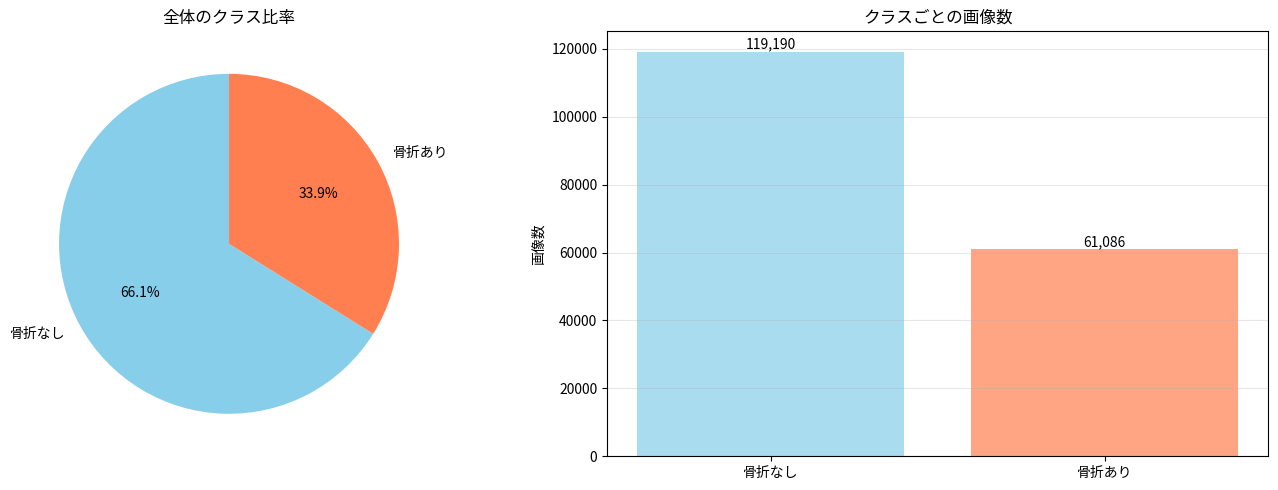

In [7]:
# 全体のクラス比率
class_counts = dataset_df['has_fracture'].value_counts()
class_ratio = dataset_df['has_fracture'].value_counts(normalize=True) * 100

print("【全体のクラス比率】")
print(f"骨折なし (0): {class_counts[0]:,} 枚 ({class_ratio[0]:.2f}%)")
print(f"骨折あり (1): {class_counts[1]:,} 枚 ({class_ratio[1]:.2f}%)")
print(f"不均衡比率: 1:{class_counts[0]/class_counts[1]:.2f}")

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 円グラフ
axes[0].pie([class_counts[0], class_counts[1]], 
            labels=['骨折なし', '骨折あり'],
            autopct='%1.1f%%',
            colors=['skyblue', 'coral'],
            startangle=90)
axes[0].set_title('全体のクラス比率')

# 棒グラフ
axes[1].bar(['骨折なし', '骨折あり'], [class_counts[0], class_counts[1]], 
            color=['skyblue', 'coral'], alpha=0.7)
axes[1].set_ylabel('画像数')
axes[1].set_title('クラスごとの画像数')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate([class_counts[0], class_counts[1]]):
    axes[1].text(i, v, f'{v:,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 6. 椎体レベル別の統計

【椎体レベル別統計】
vertebra_name   画像数  骨折数    骨折率  患者数  骨折率(%)
           T4 20634  933 0.0452   38    4.52
           T5 20634 1981 0.0960   38    9.60
           T6 20634 3485 0.1689   38   16.89
           T7 20634 5307 0.2572   38   25.72
           T8 20634 7372 0.3573   38   35.73
           T9 20091 6301 0.3136   37   31.36
          T10 20091 2952 0.1469   37   14.69
          T11 19548 1136 0.0581   36    5.81
          T12 19005 1203 0.0633   35    6.33
           L1 18462 1361 0.0737   34    7.37
           L2 18462 1346 0.0729   34    7.29
           L3 17376 1230 0.0708   32    7.08
           L4 17376  945 0.0544   32    5.44
           L5 17376  577 0.0332   32    3.32


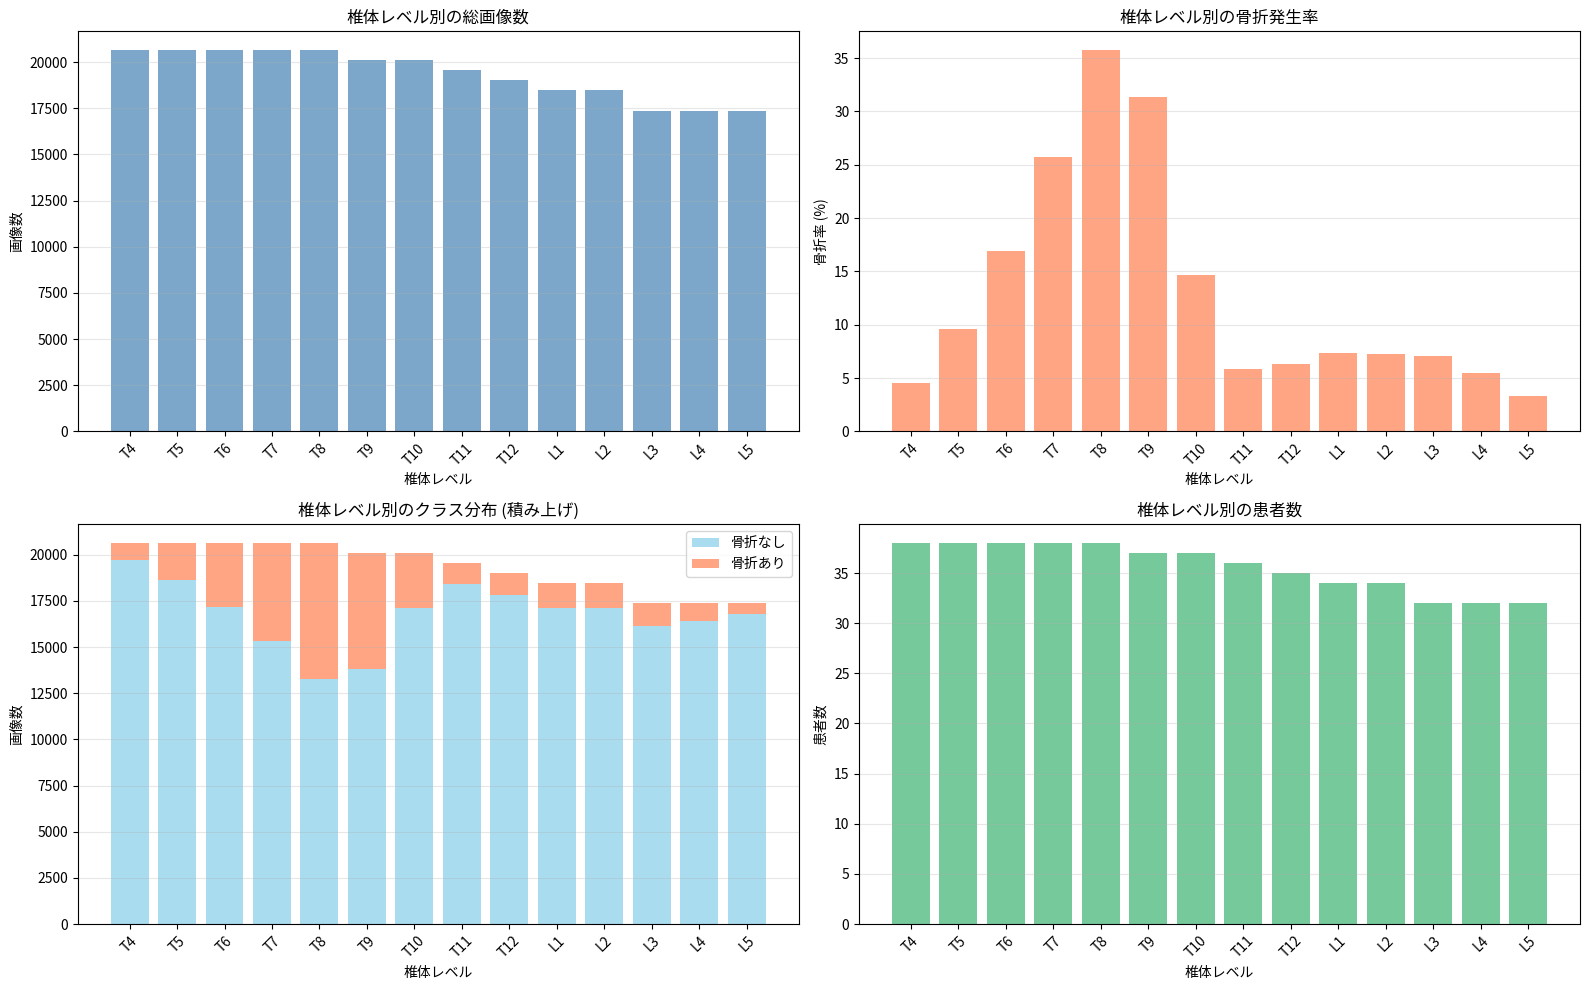

In [6]:
# 椎体レベル別の統計
vertebra_stats = dataset_df.groupby('vertebra_name').agg({
    'image_path': 'count',
    'has_fracture': ['sum', 'mean'],
    'patient_id': 'nunique'
}).round(4)

vertebra_stats.columns = ['画像数', '骨折数', '骨折率', '患者数']
vertebra_stats = vertebra_stats.reset_index()
vertebra_stats['骨折率(%)'] = vertebra_stats['骨折率'] * 100

# ソート（T4からL5の順）
vertebra_order = list(VERTEBRA_MAPPING.values())
vertebra_stats['order'] = vertebra_stats['vertebra_name'].map({v: i for i, v in enumerate(vertebra_order)})
vertebra_stats = vertebra_stats.sort_values('order').drop('order', axis=1)

print("【椎体レベル別統計】")
print(vertebra_stats.to_string(index=False))

# 可視化
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. 椎体レベル別画像数
axes[0, 0].bar(vertebra_stats['vertebra_name'], vertebra_stats['画像数'], 
               color='steelblue', alpha=0.7)
axes[0, 0].set_xlabel('椎体レベル')
axes[0, 0].set_ylabel('画像数')
axes[0, 0].set_title('椎体レベル別の総画像数')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. 椎体レベル別骨折率
axes[0, 1].bar(vertebra_stats['vertebra_name'], vertebra_stats['骨折率(%)'], 
               color='coral', alpha=0.7)
axes[0, 1].set_xlabel('椎体レベル')
axes[0, 1].set_ylabel('骨折率 (%)')
axes[0, 1].set_title('椎体レベル別の骨折発生率')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. 椎体レベル別骨折数 (積み上げ)
vertebra_stats['非骨折数'] = vertebra_stats['画像数'] - vertebra_stats['骨折数']
axes[1, 0].bar(vertebra_stats['vertebra_name'], vertebra_stats['非骨折数'], 
               label='骨折なし', color='skyblue', alpha=0.7)
axes[1, 0].bar(vertebra_stats['vertebra_name'], vertebra_stats['骨折数'], 
               bottom=vertebra_stats['非骨折数'],
               label='骨折あり', color='coral', alpha=0.7)
axes[1, 0].set_xlabel('椎体レベル')
axes[1, 0].set_ylabel('画像数')
axes[1, 0].set_title('椎体レベル別のクラス分布 (積み上げ)')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. 椎体レベル別患者数
axes[1, 1].bar(vertebra_stats['vertebra_name'], vertebra_stats['患者数'], 
               color='mediumseagreen', alpha=0.7)
axes[1, 1].set_xlabel('椎体レベル')
axes[1, 1].set_ylabel('患者数')
axes[1, 1].set_title('椎体レベル別の患者数')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 7. 方向別の統計

【方向別統計】
direction_jp   画像数   骨折数    骨折率  骨折率(%)
         冠状断 60092 17694 0.2944   29.44
         横断面 60092 21522 0.3582   35.82
         矢状断 60092 21870 0.3639   36.39


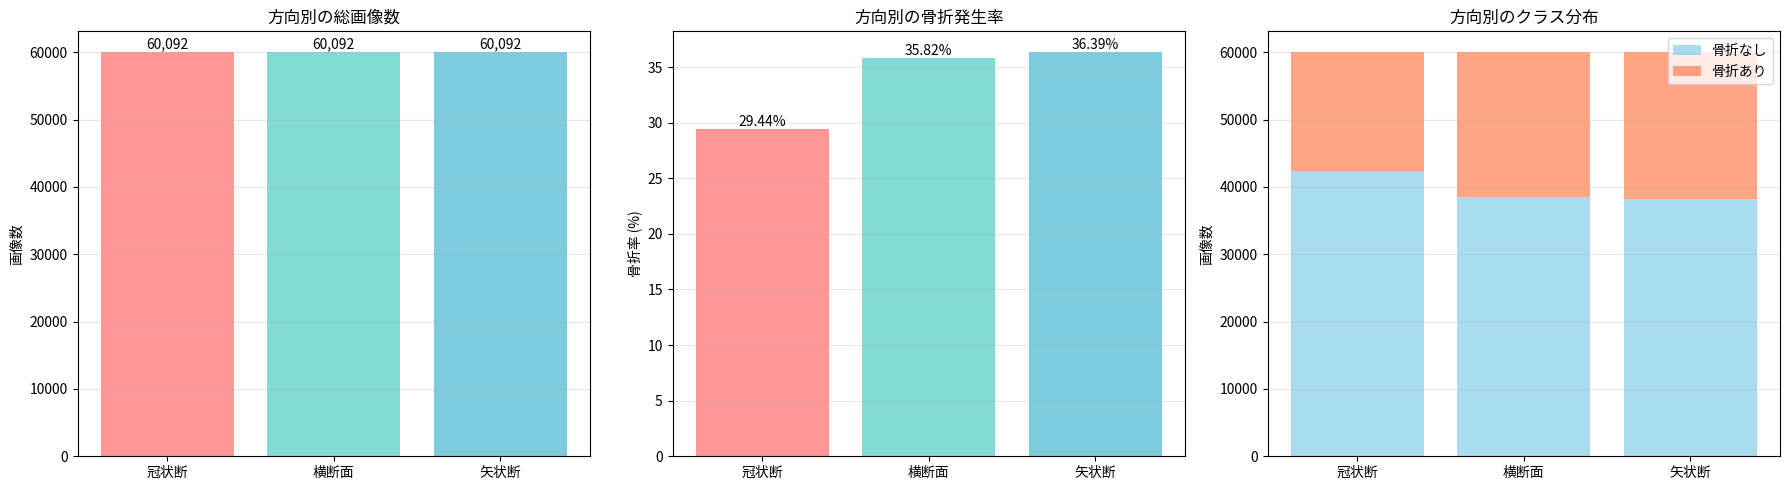

In [8]:
# 方向別の統計
direction_stats = dataset_df.groupby('direction_jp').agg({
    'image_path': 'count',
    'has_fracture': ['sum', 'mean']
}).round(4)

direction_stats.columns = ['画像数', '骨折数', '骨折率']
direction_stats = direction_stats.reset_index()
direction_stats['骨折率(%)'] = direction_stats['骨折率'] * 100

print("【方向別統計】")
print(direction_stats.to_string(index=False))

# 可視化
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. 方向別画像数
axes[0].bar(direction_stats['direction_jp'], direction_stats['画像数'], 
            color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.7)
axes[0].set_ylabel('画像数')
axes[0].set_title('方向別の総画像数')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(direction_stats['画像数']):
    axes[0].text(i, v, f'{v:,}', ha='center', va='bottom')

# 2. 方向別骨折率
axes[1].bar(direction_stats['direction_jp'], direction_stats['骨折率(%)'], 
            color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.7)
axes[1].set_ylabel('骨折率 (%)')
axes[1].set_title('方向別の骨折発生率')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(direction_stats['骨折率(%)']):
    axes[1].text(i, v, f'{v:.2f}%', ha='center', va='bottom')

# 3. 方向別クラス分布 (積み上げ)
direction_stats['非骨折数'] = direction_stats['画像数'] - direction_stats['骨折数']
x_pos = np.arange(len(direction_stats))
axes[2].bar(x_pos, direction_stats['非骨折数'], label='骨折なし', 
            color='skyblue', alpha=0.7)
axes[2].bar(x_pos, direction_stats['骨折数'], bottom=direction_stats['非骨折数'],
            label='骨折あり', color='coral', alpha=0.7)
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(direction_stats['direction_jp'])
axes[2].set_ylabel('画像数')
axes[2].set_title('方向別のクラス分布')
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 8. 患者別の統計

【患者別統計】 (総患者数: 38)
patient_id   画像数  骨折数    骨折率  椎体数  骨折率(%)
    AI1003  4344 1576 0.3628    4   36.28
    AI1010  3258 1778 0.5457    3   54.57
    AI1012  4344 1944 0.4475    4   44.75
    AI1015  3258 1066 0.3272    3   32.72
    AI1016  4344 1186 0.2730    4   27.30
    AI1017  3258 1068 0.3278    3   32.78
    AI1021  6516 2062 0.3165    6   31.65
    AI1025  4344 1802 0.4148    4   41.48
    AI1027  3258 2160 0.6630    3   66.30
    AI1030  2172  924 0.4254    2   42.54
    AI1035  4344 1552 0.3573    4   35.73
    AI1038 10860 2430 0.2238   10   22.38
    AI1039  7602 2128 0.2799    7   27.99
    AI1043  4344 1228 0.2827    4   28.27
    AI1045  9774 2634 0.2695    9   26.95
    AI1046  3258 1594 0.4893    3   48.93
    AI1047  5430 1782 0.3282    5   32.82
    AI1049  8688 2332 0.2684    8   26.84
    AI1051  5430 1582 0.2913    5   29.13
    AI1052  4344 1534 0.3531    4   35.31


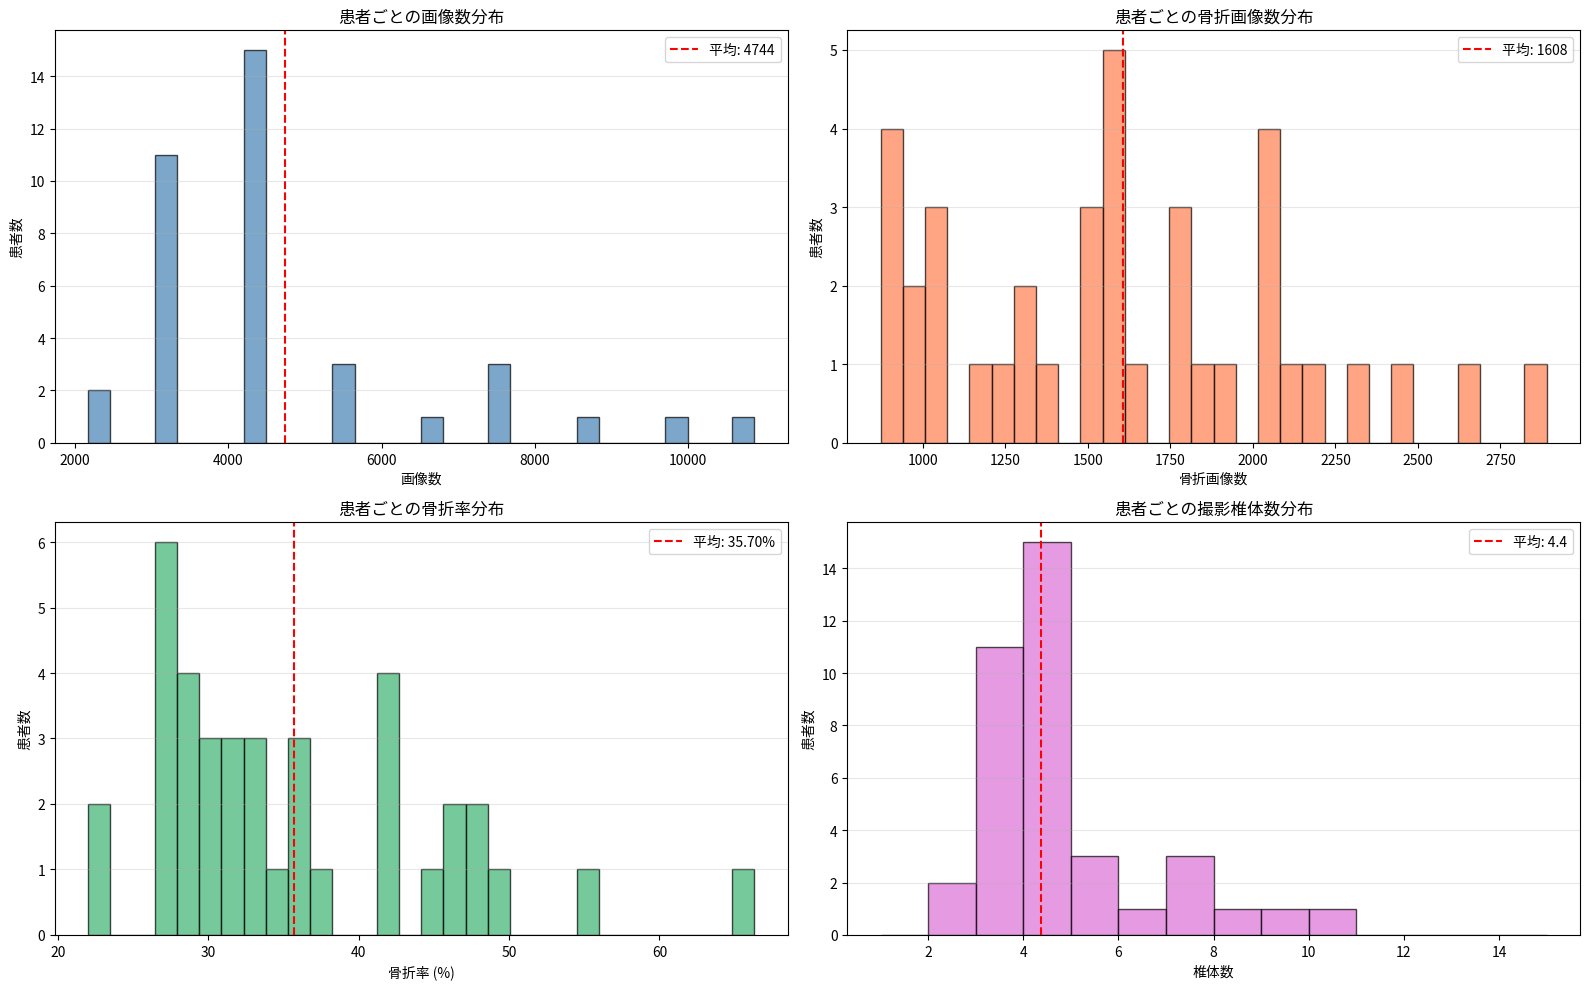


【患者統計サマリー】
平均画像数/患者: 4744.1 (±1994.8)
平均骨折数/患者: 1607.5 (±518.1)
平均骨折率/患者: 35.70% (±9.64%)
平均椎体数/患者: 4.4 (±1.8)


In [9]:
# 患者別の統計
patient_stats = dataset_df.groupby('patient_id').agg({
    'image_path': 'count',
    'has_fracture': ['sum', 'mean'],
    'vertebra_id': 'nunique'
}).round(4)

patient_stats.columns = ['画像数', '骨折数', '骨折率', '椎体数']
patient_stats = patient_stats.reset_index()
patient_stats['骨折率(%)'] = patient_stats['骨折率'] * 100
patient_stats = patient_stats.sort_values('patient_id')

print(f"【患者別統計】 (総患者数: {len(patient_stats)})")
print(patient_stats.head(20).to_string(index=False))

# 患者ごとの画像数分布
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. 患者ごとの画像数
axes[0, 0].hist(patient_stats['画像数'], bins=30, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('画像数')
axes[0, 0].set_ylabel('患者数')
axes[0, 0].set_title('患者ごとの画像数分布')
axes[0, 0].axvline(patient_stats['画像数'].mean(), color='red', linestyle='--', 
                   label=f'平均: {patient_stats["画像数"].mean():.0f}')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. 患者ごとの骨折画像数
axes[0, 1].hist(patient_stats['骨折数'], bins=30, color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('骨折画像数')
axes[0, 1].set_ylabel('患者数')
axes[0, 1].set_title('患者ごとの骨折画像数分布')
axes[0, 1].axvline(patient_stats['骨折数'].mean(), color='red', linestyle='--',
                   label=f'平均: {patient_stats["骨折数"].mean():.0f}')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. 患者ごとの骨折率
axes[1, 0].hist(patient_stats['骨折率(%)'], bins=30, color='mediumseagreen', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('骨折率 (%)')
axes[1, 0].set_ylabel('患者数')
axes[1, 0].set_title('患者ごとの骨折率分布')
axes[1, 0].axvline(patient_stats['骨折率(%)'].mean(), color='red', linestyle='--',
                   label=f'平均: {patient_stats["骨折率(%)"].mean():.2f}%')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. 患者ごとの椎体数
axes[1, 1].hist(patient_stats['椎体数'], bins=range(1, 16), color='orchid', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('椎体数')
axes[1, 1].set_ylabel('患者数')
axes[1, 1].set_title('患者ごとの撮影椎体数分布')
axes[1, 1].axvline(patient_stats['椎体数'].mean(), color='red', linestyle='--',
                   label=f'平均: {patient_stats["椎体数"].mean():.1f}')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n【患者統計サマリー】")
print(f"平均画像数/患者: {patient_stats['画像数'].mean():.1f} (±{patient_stats['画像数'].std():.1f})")
print(f"平均骨折数/患者: {patient_stats['骨折数'].mean():.1f} (±{patient_stats['骨折数'].std():.1f})")
print(f"平均骨折率/患者: {patient_stats['骨折率(%)'].mean():.2f}% (±{patient_stats['骨折率(%)'].std():.2f}%)")
print(f"平均椎体数/患者: {patient_stats['椎体数'].mean():.1f} (±{patient_stats['椎体数'].std():.1f})")

## 9. 骨折領域サイズ分析

【骨折領域サイズ分析】
骨折画像数: 61,086

骨折領域ピクセル比率の統計:
  平均: 2.4329%
  中央値: 1.6452%
  標準偏差: 2.4695%
  最小: 0.0061%
  最大: 18.3114%


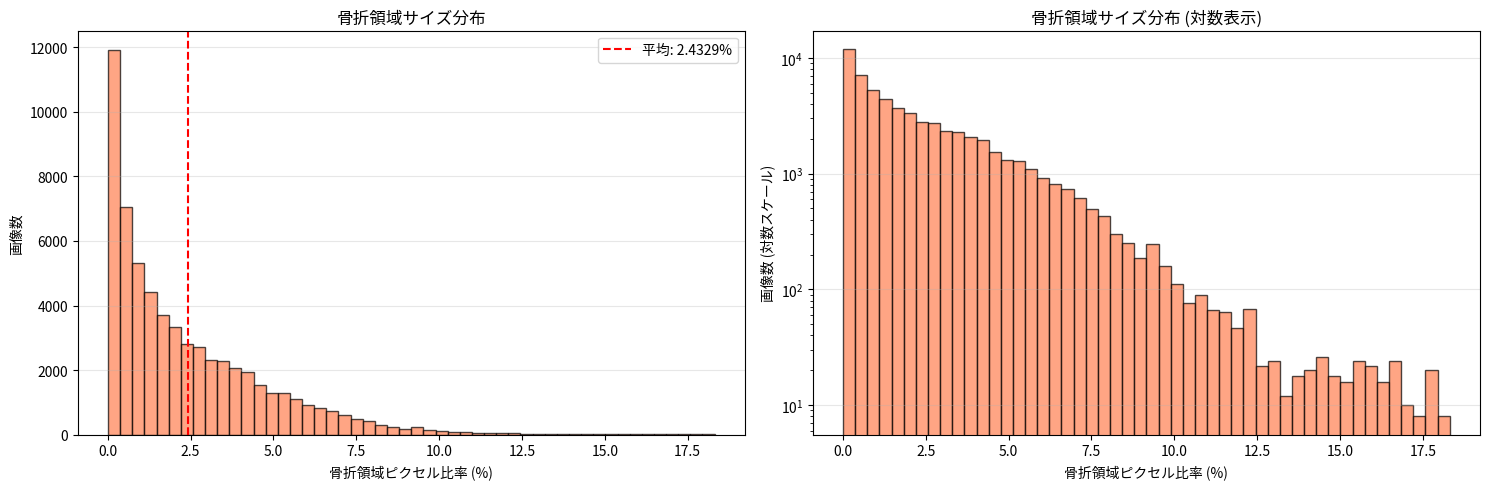

In [10]:
# 骨折ありの画像のみをフィルタ
fracture_df = dataset_df[dataset_df['has_fracture'] == 1].copy()

print(f"【骨折領域サイズ分析】")
print(f"骨折画像数: {len(fracture_df):,}")

# 骨折ピクセル比率の統計
print(f"\n骨折領域ピクセル比率の統計:")
print(f"  平均: {fracture_df['fracture_pixel_ratio'].mean()*100:.4f}%")
print(f"  中央値: {fracture_df['fracture_pixel_ratio'].median()*100:.4f}%")
print(f"  標準偏差: {fracture_df['fracture_pixel_ratio'].std()*100:.4f}%")
print(f"  最小: {fracture_df['fracture_pixel_ratio'].min()*100:.4f}%")
print(f"  最大: {fracture_df['fracture_pixel_ratio'].max()*100:.4f}%")

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 1. 骨折領域比率のヒストグラム
axes[0].hist(fracture_df['fracture_pixel_ratio'] * 100, bins=50, 
             color='coral', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('骨折領域ピクセル比率 (%)')
axes[0].set_ylabel('画像数')
axes[0].set_title('骨折領域サイズ分布')
axes[0].axvline(fracture_df['fracture_pixel_ratio'].mean()*100, 
                color='red', linestyle='--', 
                label=f'平均: {fracture_df["fracture_pixel_ratio"].mean()*100:.4f}%')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# 2. 対数スケールでの表示
axes[1].hist(fracture_df['fracture_pixel_ratio'] * 100, bins=50, 
             color='coral', alpha=0.7, edgecolor='black', log=True)
axes[1].set_xlabel('骨折領域ピクセル比率 (%)')
axes[1].set_ylabel('画像数 (対数スケール)')
axes[1].set_title('骨折領域サイズ分布 (対数表示)')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 10. 画像サンプル可視化

In [11]:
def visualize_samples(df: pd.DataFrame, 
                      n_samples: int = 5,
                      show_fracture_only: bool = False,
                      vertebra_name: Optional[str] = None,
                      direction: Optional[str] = None):
    """
    ランダムサンプルを可視化
    """
    # フィルタリング
    filtered_df = df.copy()
    if show_fracture_only:
        filtered_df = filtered_df[filtered_df['has_fracture'] == 1]
    if vertebra_name:
        filtered_df = filtered_df[filtered_df['vertebra_name'] == vertebra_name]
    if direction:
        filtered_df = filtered_df[filtered_df['direction'] == direction]
    
    if len(filtered_df) == 0:
        print("⚠️ 条件に一致する画像がありません")
        return
    
    # ランダムサンプリング
    samples = filtered_df.sample(min(n_samples, len(filtered_df)))
    
    fig, axes = plt.subplots(n_samples, 2, figsize=(10, 5*n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (_, row) in enumerate(samples.iterrows()):
        # 画像読み込み
        img_path = DATASET_ROOT / row['image_path']
        img = load_png_image(img_path)
        
        # 画像表示
        axes[idx, 0].imshow(img, cmap='gray')
        axes[idx, 0].set_title(
            f"{row['vertebra_name']} - {row['direction_jp']} - {row['patient_id']}\n"
            f"骨折: {'あり' if row['has_fracture'] else 'なし'}"
        )
        axes[idx, 0].axis('off')
        
        # マスク表示
        if row['mask_path'] and row['has_fracture']:
            mask_path = DATASET_ROOT / row['mask_path']
            if mask_path.exists():
                mask = load_mask_image(mask_path)
                axes[idx, 1].imshow(img, cmap='gray')
                axes[idx, 1].imshow(mask, cmap='Reds', alpha=0.5)
                axes[idx, 1].set_title(
                    f"マスクオーバーレイ\n"
                    f"骨折領域: {row['fracture_pixel_ratio']*100:.3f}%"
                )
            else:
                axes[idx, 1].text(0.5, 0.5, 'マスクなし', ha='center', va='center')
        else:
            axes[idx, 1].imshow(img, cmap='gray')
            axes[idx, 1].set_title('骨折なし')
        
        axes[idx, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

print("✅ 可視化関数定義完了")

✅ 可視化関数定義完了


### 10.1 ランダムサンプル (骨折あり)

【骨折ありのランダムサンプル】


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/data/dataset/data/dataset/slice_image/slice_imageAI1017_vert29AxialAVGProjectionIntensity0208/A1017_V29_077_000.png'

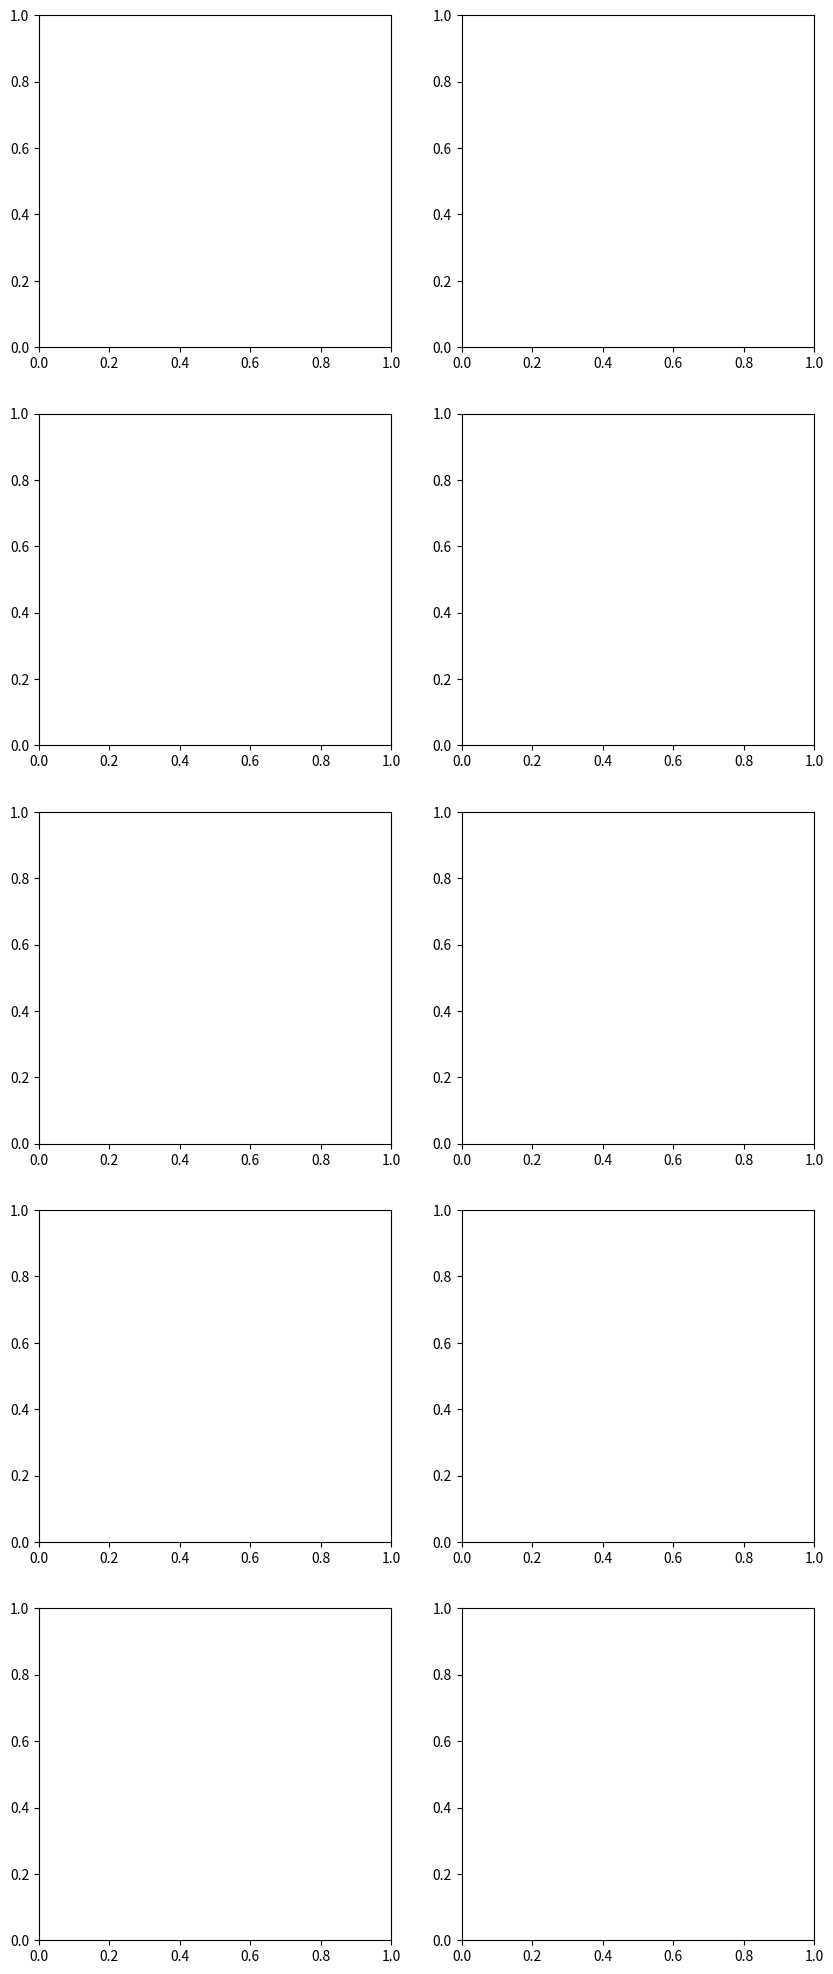

In [12]:
print("【骨折ありのランダムサンプル】")
visualize_samples(dataset_df, n_samples=5, show_fracture_only=True)

### 10.2 ランダムサンプル (骨折なし)

In [ ]:
print("【骨折なしのランダムサンプル】")
visualize_samples(
    dataset_df[dataset_df['has_fracture'] == 0], 
    n_samples=5, 
    show_fracture_only=False
)

### 10.3 特定椎体レベルのサンプル

In [ ]:
# 例: T12 (椎体ID 35) の骨折サンプル
print("【T12の骨折サンプル】")
visualize_samples(dataset_df, n_samples=3, show_fracture_only=True, vertebra_name='T12')

### 10.4 3方向比較

In [ ]:
def compare_three_directions(df: pd.DataFrame, patient_id: str, vertebra_name: str):
    """
    同一患者・椎体の3方向画像を比較
    """
    subset = df[(df['patient_id'] == patient_id) & 
                (df['vertebra_name'] == vertebra_name)]
    
    if len(subset) == 0:
        print(f"⚠️ {patient_id} の {vertebra_name} が見つかりません")
        return
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'{patient_id} - {vertebra_name} の3方向比較', fontsize=16, fontweight='bold')
    
    for col_idx, direction in enumerate(['Axial', 'Coron', 'Sagit']):
        direction_data = subset[subset['direction'] == direction]
        
        if len(direction_data) == 0:
            axes[0, col_idx].text(0.5, 0.5, f'{direction}\nデータなし', 
                                  ha='center', va='center')
            axes[0, col_idx].axis('off')
            axes[1, col_idx].axis('off')
            continue
        
        # 中央スライスを取得
        sample = direction_data.iloc[len(direction_data) // 2]
        
        # 画像読み込み
        img_path = DATASET_ROOT / sample['image_path']
        img = load_png_image(img_path)
        
        # 画像表示
        axes[0, col_idx].imshow(img, cmap='gray')
        axes[0, col_idx].set_title(
            f"{DIRECTION_MAPPING[direction]}\n"
            f"骨折: {'あり' if sample['has_fracture'] else 'なし'}"
        )
        axes[0, col_idx].axis('off')
        
        # マスク表示
        if sample['mask_path'] and sample['has_fracture']:
            mask_path = DATASET_ROOT / sample['mask_path']
            if mask_path.exists():
                mask = load_mask_image(mask_path)
                axes[1, col_idx].imshow(img, cmap='gray')
                axes[1, col_idx].imshow(mask, cmap='Reds', alpha=0.5)
                axes[1, col_idx].set_title(
                    f"マスク ({sample['fracture_pixel_ratio']*100:.3f}%)"
                )
            else:
                axes[1, col_idx].imshow(img, cmap='gray')
                axes[1, col_idx].set_title('マスクなし')
        else:
            axes[1, col_idx].imshow(img, cmap='gray')
            axes[1, col_idx].set_title('骨折なし')
        
        axes[1, col_idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# 骨折のある患者・椎体を探す
fracture_cases = dataset_df[dataset_df['has_fracture'] == 1][['patient_id', 'vertebra_name']].drop_duplicates()
if len(fracture_cases) > 0:
    sample_case = fracture_cases.iloc[0]
    print(f"【3方向比較サンプル: {sample_case['patient_id']} - {sample_case['vertebra_name']}】")
    compare_three_directions(dataset_df, sample_case['patient_id'], sample_case['vertebra_name'])

## 11. ヒートマップ: 椎体×方向のクラス比率

In [ ]:
# 椎体レベル × 方向のクロス集計
cross_tab = pd.crosstab(
    dataset_df['vertebra_name'], 
    dataset_df['direction_jp'], 
    dataset_df['has_fracture'], 
    aggfunc='mean'
) * 100  # パーセント表示

# ソート
vertebra_order = list(VERTEBRA_MAPPING.values())
cross_tab = cross_tab.reindex(vertebra_order)

# ヒートマップ描画
plt.figure(figsize=(10, 8))
sns.heatmap(cross_tab, annot=True, fmt='.2f', cmap='YlOrRd', 
            cbar_kws={'label': '骨折率 (%)'})
plt.title('椎体レベル × 方向 の骨折率ヒートマップ', fontsize=14, fontweight='bold')
plt.xlabel('方向')
plt.ylabel('椎体レベル')
plt.tight_layout()
plt.show()

print("【椎体レベル × 方向 の骨折率 (%)】")
print(cross_tab)

## 12. まとめと観察結果

このノートブックで明らかになった主要な知見:

### データセット概要
- 総画像数: 約45万枚
- クラス不均衡比率: 骨折なし vs 骨折あり
- 椎体レベル: T4~L5 (14レベル)
- 撮影方向: Axial, Coronal, Sagittal (3方向)

### クラス不均衡への対応
- 損失関数での重み付け
- Focal Loss / Focal Tversky Lossの使用
- データ拡張の適用

### 骨折領域の特性
- 非常に小さい領域 (平均ピクセル比率 < 1%)
- 椎体レベルによる発生率の違い
- 方向による見え方の違い

### 次のステップ
1. マルチタスク学習 (分類 + セグメンテーション)
2. アテンション機構の導入
3. 3D統合による精度向上

## 13. カスタム分析セル

以下のセルを使って、追加の探索的分析を自由に実行できます。

In [ ]:
# カスタム分析用セル
# 例: 特定の条件でフィルタリングして可視化

# 利用可能な患者IDを確認
print("利用可能な患者ID:")
print(sorted(dataset_df['patient_id'].unique()))

# ここに追加のコードを記述